In [3]:
# --------------------
# Libraries
# --------------------

from pathlib import Path

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
import torch
from umap import UMAP

# sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

# Optuna
import optuna

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os

# --------------------
# global variables
# --------------------
model_ckpt = "distilbert-base-uncased"
data_dir = Path("~/workspace/nlp_exploration/data")
device = "cuda" if torch.cuda.is_available() else "cpu"

ImportError: cannot import name 'UMAP' from 'umap' (c:\Users\tddnth\workspace\sandbox_exploration\.venv\Lib\site-packages\umap\__init__.py)

# Chargement du jeu de donné

Le jeu de données "emotions" est composé de trois sous-ensembles distincts : "train" (entraînement), "validation" et "test". Ces sous-ensembles servent à des fins spécifiques dans le processus de développement et d'évaluation d'un modèle. 

1. **Ensemble d'entraînement ("train") :**
   - Fonction : Utilisé pour entraîner le modèle d'apprentissage automatique.
   - Objectif : Permettre au modèle d'ajuster ses paramètres en fonction des données fournies, afin d'apprendre les motifs et les caractéristiques associés aux différentes classes d'émotions.

2. **Ensemble de validation ("validation") :**
   - Fonction : Utilisé pour ajuster les hyperparamètres du modèle et éviter le surajustement.
   - Objectif : Évaluer la performance du modèle sur des données distinctes de celles utilisées pour l'entraînement, permettant ainsi d'optimiser les paramètres du modèle tout en évitant une adaptation trop spécifique aux données d'entraînement.

3. **Ensemble de test ("test") :**
   - Fonction : Utilisé pour évaluer la performance finale du modèle.
   - Objectif : Fournir une évaluation objective du modèle sur des données qu'il n'a jamais vues auparavant, simulant ainsi son comportement réel lorsqu'il est confronté à de nouvelles données.

En utilisant ces trois sous-ensembles de manière distincte, on s'assure que le modèle est capable de généraliser ses connaissances à des données inconnues tout en étant suffisamment robuste pour faire face à des scénarios du monde réel.

In [3]:
emotions = load_dataset(path="emotion")

c:\Users\tddnth\workspace\sandbox_exploration\.venv\Lib\site-packages\datasets\load.py:1429: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [3]:
# Création d'une nouvelle colonne dans les jeux de données "label_name" afin de rendre plus explicite le nom de la cible
emotions_names = emotions["train"].features["label"].names

def label_int2str(batch):
    return {
        "label_name": [emotions_names[idx] for idx in batch["label"]]
    }

emotions = emotions.map(label_int2str, batched=True)

La figure ci-dessous démontre que les proportions relatives des différentes classes d'émotions sont maintenues à travers les ensembles d'entraînement et de validation. Cela indique que la distribution des données lors de la constitution de ces ensembles a été réalisée par stratification.

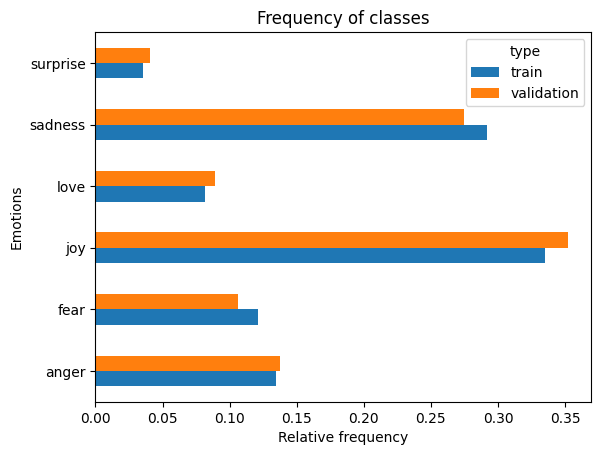

In [4]:
emotions.set_format(type="pandas")

train = emotions["train"][:]
train["type"] = "train"
validation = emotions["validation"][:]
validation["type"] = "validation"

ds = pd.concat([train, validation])

ds.groupby("type").label_name.value_counts(normalize=True, ascending=True).unstack(0).plot.barh()
plt.title("Frequency of classes")
plt.ylabel("Emotions")
plt.xlabel("Relative frequency")
plt.show()

emotions.reset_format()

Nous constatons un déséquilibre au niveau des classes. Afin de traiter ce type de déséquilibre dans la variable cible, il est possible d'utiliser la bibliothèque [imbalanced-learn](https://imbalanced-learn.org/stable/).

# Subword tokenization

In [5]:
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_ckpt)

## Quelques attributs et méthodes intéressants

### Méthodes de conversion

In [6]:
text = "My cat loves sleeping all day long."
encoded_text = tokenizer(text)
# ids -> tokens
# tokenize
tokens = tokenizer.convert_ids_to_tokens(encoded_text["input_ids"])
print(f"tokens: {tokens}")

# tokens -> ids
ids = tokenizer.convert_tokens_to_ids(tokens)
print(f"ids: {ids}")


# tokens -> strings
string = tokenizer.convert_tokens_to_string(tokens)
print(f"string: {string}")

print(f"size: {encoded_text['input_ids']}")


tokens: ['[CLS]', 'my', 'cat', 'loves', 'sleeping', 'all', 'day', 'long', '.', '[SEP]']
ids: [101, 2026, 4937, 7459, 5777, 2035, 2154, 2146, 1012, 102]
string: [CLS] my cat loves sleeping all day long. [SEP]
size: [101, 2026, 4937, 7459, 5777, 2035, 2154, 2146, 1012, 102]


### Attributs sur l'état d'entrainement du modèle

In [7]:
print(f"Taille du vocabulaire: {tokenizer.vocab_size}")
print(f"Noms des éléments retournés par défault par le tokenizer: {tokenizer.model_input_names}")
print("Taille maximale acceptée par ce modèle et autres dérivés du modèle:")
print(tokenizer.max_model_input_sizes)
print(f"Taille maximale acceptée par ce modèle: {tokenizer.model_max_length}")
print(f"Nom du modèle: {tokenizer.name_or_path}")
print(f"Tokens spéciaux: {tokenizer.all_special_tokens}")
print(f"Id des tokens spéciaux: {tokenizer.all_special_ids}")

# L'accès à tout le vocabulaire du modèle se fait par le dictionnaire : Tokenizer.vocab
print(f"Fichiers contenant le vocabulaire: {tokenizer.vocab_files_names}")

Taille du vocabulaire: 30522
Noms des éléments retournés par défault par le tokenizer: ['input_ids', 'attention_mask']
Taille maximale acceptée par ce modèle et autres dérivés du modèle:
{'distilbert-base-uncased': 512, 'distilbert-base-uncased-distilled-squad': 512, 'distilbert-base-cased': 512, 'distilbert-base-cased-distilled-squad': 512, 'distilbert-base-german-cased': 512, 'distilbert-base-multilingual-cased': 512}
Taille maximale acceptée par ce modèle: 512
Nom du modèle: distilbert-base-uncased
Tokens spéciaux: ['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']
Id des tokens spéciaux: [100, 102, 0, 101, 103]
Fichiers contenant le vocabulaire: {'vocab_file': 'vocab.txt', 'tokenizer_file': 'tokenizer.json'}


## Tokenization du jeu de données

La classe mére de DistilbertTokenizer(PretrainedTokenizer) contient aussi des méthodes, attributs et propriétés intéressantes, e.g., [PreTrainedTokenizer.is_fast](https://github.com/huggingface/transformers/blob/main/src/transformers/tokenization_utils.py#L375).

Si la propriété `is_fast` est vrai, alors le tokenizer utilise une méthode de tokenization optimisée et plus rapide écrite en Rust.

In [8]:
tokenizer.is_fast

True

Tokenizer.tokenize() --> DistilbertTokenizer(PreTrainedTokenizer(PreTrainedTokenizerBase)) [PreTrainedTokenizer.tokenize()](https://github.com/huggingface/transformers/blob/main/src/transformers/tokenization_utils.py#L541C9-L541C17)

La methode [PreTrainedTokenizerBase.\_\_call__()](https://github.com/huggingface/transformers/blob/main/src/transformers/tokenization_utils_base.py#L2729) est appelée par: tokenizer(batch). Ensuite elle renvoie vers _call_one -> encode_plus... à la fin du pipe, le texte est tokenizé. Cette méthode peut être consultée pour accéder à tous les paramètres utiles.

Quelques uns des arguments intéressants sont listés ci-dessous:

- **text**: Union[TextInput, PreTokenizedInput, List[TextInput], List[PreTokenizedInput]] = None,
- **text_pair**: Optional[Union[TextInput, PreTokenizedInput, List[TextInput], List[PreTokenizedInput]]] = None,
- **text_target**: Union[TextInput, PreTokenizedInput, List[TextInput], List[PreTokenizedInput]] = None,
- **text_pair_target**: Optional[Union[TextInput, PreTokenizedInput, List[TextInput], List[PreTokenizedInput]]] = None,
- **add_special_tokens**: bool = True,
- **padding**: Union[bool, str, PaddingStrategy] = False,
- **truncation**: Union[bool, str, TruncationStrategy] = None,
- **max_length**: Optional[int] = None,
- **stride**: int = 0,
- **is_split_into_words**: bool = False,
- **pad_to_multiple_of**: Optional[int] = None,
- **return_tensors**: Optional[Union[str, TensorType]] = None,
- **return_token_type_ids**: Optional[bool] = None,
- **return_attention_mask**: Optional[bool] = None,
- **return_overflowing_tokens**: bool = False,
- **return_special_tokens_mask**: bool = False,
- **return_offsets_mapping**: bool = False,
- **return_length**: bool = False,
- **verbose**: bool = True,


In [9]:
def tokenize_batch(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, return_tensors="pt")

encoded_emotions = emotions.map(function=tokenize_batch, batched=True, batch_size=1000)

### Remarque importante : Mise des informations encodées au format pytorch

Malgré la mention `return_tensors="pt"` dans les arguments du tokenizer, les valeurs `input_ids` et `attention_mask` ne sont pas codées comme des tenseurs pytorch:

In [10]:
# print(encoded_emotions["train"]["input_ids"][0].size())

Une solution consiste à ne pas utiliser l'argument `return_tensors`, mais plutôt à utiliser la méthode `set_format` de la classe `DatasetDict` de Hugging Face pour convertir les colonnes souhaitées au format tensoriel de PyTorch, comme illustré ci-dessous. 

La méthode `set_format` effectue le changement "in place", ce qui signifie qu'aucune assignation n'est nécessaire pour pérenniser la modification. À la place, l'objet est mis à jour avec le nouveau format. Pour revenir au format d'origine, il suffit d'utiliser la méthode `reset_format`.

In [11]:
encoded_emotions.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
print(encoded_emotions["train"]["input_ids"][0].size())

torch.Size([70])


Néanmoins, il faut noter que cet argument fonctionne correctement pour la tokenization de sequence simple, or utilisation de la méthode `map` de DataSetDict:

In [12]:
sequence = "Hello I am sequence"
encoded_sequence = tokenizer(sequence, return_tensors="pt")
print(encoded_sequence["input_ids"][0]) 

tensor([ 101, 7592, 1045, 2572, 5537,  102])


# Entrainement de Distilbert comme analyseur de sentiment

## En utilisant le Transformer comme extracteur de caractéristiques (Feature Extractors)

### Quelques explications

- [AutoModel](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoModel)
- [AutoDistilbert](https://huggingface.co/docs/transformers/main/en/model_doc/distilbert#transformers.DistilBertModel)

L'objectif de ces classes est de convertir les __token encodings__ en __embeddings__ avant d'en retourner le __hidden state__ du token initial.

In [13]:
model = AutoModel.from_pretrained(pretrained_model_name_or_path=model_ckpt).to(device)

La méthode [is\_parallelizable](https://github.com/huggingface/transformers/blob/v4.36.2/src/transformers/modeling_utils.py#L1129) de la classe `PreTrainedModel` permet de déterminer si ce modèle prend en charge la parallélisation du modèle.

Lorsque la méthode `is_parallelizable` pour un modèle, comme DistilBERT par exemple, est définie comme faux, cela signifie que le modèle n'est pas conçu pour être facilement parallélisable dans le cadre du traitement distribué ou de la parallélisation du modèle. En d'autres termes, il peut être plus difficile de diviser efficacement le travail entre plusieurs processeurs ou dispositifs de calcul.

Cela peut avoir des implications sur les performances et l'évolutivité du modèle lorsqu'il est déployé dans un environnement distribué ou sur des architectures matérielles spécifiques. Un modèle non parallélisable pourrait présenter des limitations en termes de vitesse d'entraînement ou d'inférence lorsque la charge de travail est répartie sur plusieurs unités de traitement, car il ne tire pas pleinement parti des avantages de la parallélisation.

Dans le cas de DistilBERT, qui a `is_parallelizable` défini comme faux, il est important de prendre en compte ces considérations lors de l'intégration ou du déploiement du modèle dans des environnements où la parallélisation du modèle est une exigence ou une considération importante.

In [14]:
print(f"Est-ce que le modèle est parallélisable? {model.is_parallelizable}")

Est-ce que le modèle est parallélisable? False


L'appel de fonction `model(**inputs)` opère sur un objet construit à partir de la méthode `from_pretrained` de la classe `AutoModel`. Lors de cet appel, l'objet retourné par la méthode `from_pretrained` est une instance de la classe [DistilBertModel(DistilBertPreTrainedModel)](https://github.com/huggingface/transformers/blob/v4.36.2/src/transformers/models/distilbert/modeling_distilbert.py#L702). Il est important de noter que cette classe [DistilBertPreTrainedModel](https://github.com/huggingface/transformers/blob/v4.36.2/src/transformers/models/distilbert/modeling_distilbert.py#L616) hérite de [PreTrainedModel](https://github.com/huggingface/transformers/blob/v4.36.2/src/transformers/modeling_utils.py#L1106), elle-même héritant de la classe [Module](https://github.com/pytorch/pytorch/blob/v2.1.2/torch/nn/modules/module.py#L375) de PyTorch.

Pour comprendre l'action effectuée par l'appel à l'objet `model(...)`, il est nécessaire de remonter la hiérarchie jusqu'à la méthode [\_\_call__](https://github.com/pytorch/pytorch/blob/v2.1.2/torch/nn/modules/module.py#L1641), héritée de `DistilBertModel` par son ancêtre `nn.Module`. Ensuite, `__call__` conduit à [_wrapped_call_impl](https://github.com/pytorch/pytorch/blob/v2.1.2/torch/nn/modules/module.py#L1514), qui à son tour renvoie vers [_call_impl](https://github.com/pytorch/pytorch/blob/v2.1.2/torch/nn/modules/module.py#L1520). En prenant quelques raccourcis, cela aboutit finalement à un appel de la méthode [forward](https://github.com/huggingface/transformers/blob/v4.36.2/src/transformers/models/distilbert/modeling_distilbert.py#L781) de la classe `DistilBertModel`. Ainsi, l'action principale de l'appel `model(**inputs)` est d'exécuter la méthode `forward` de la classe `DistilBertModel`.

Voici les arguments pris par la fonction `forward`: 

- **input_ids**: Optional[torch.Tensor] = None,
- **attention_mask**: Optional[torch.Tensor] = None,
- **head_mask**: Optional[torch.Tensor] = None,
- **inputs_embeds**: Optional[torch.Tensor] = None,
- **output_attentions**: Optional[bool] = None,
- **output_hidden_states**: Optional[bool] = None,
- **return_dict**: Optional[bool] = None,


L'appel à [torch.no_grad()](https://pytorch.org/docs/2.1/generated/torch.no_grad.html#torch.no_grad) désactive le calcul des gradients. En l'utilisant, on réduit la consommation de mémoire lors de l'inférence, garantissant que les calculs ne requièrent pas de gradients. Dans ce mode, les résultats ont requires_grad=False, sauf pour les fonctions d'usine. Ce gestionnaire de contexte agit au niveau du thread et peut également être utilisé comme décorateur.

### Extraction de la dernière couche cachée associé au token [CLS]

-> Expliquer pourquoi uniquement se concentrer sur le token [CLS]

In [15]:

def extract_hidden_states(batch) -> np:
    # TODO: Paralléliser par batch
    batch_to_device = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        hidden_states = model(**batch_to_device)
    return {
        # Only return le [CLS] information (last_hidden_state[:, 0])
        "last_hidden_state": hidden_states.last_hidden_state[:, 0].cpu().numpy()
    }
    
hidden_emotions = encoded_emotions.map(function=extract_hidden_states, 
                                       batched=True, batch_size=1000, 
                                       num_proc=1)

La méthode [Tensor.cpu](https://pytorch.org/docs/stable/generated/torch.Tensor.cpu.html#torch.Tensor.cpu) dans PyTorch permet de déplacer une copie d'un tenseur, une structure multidimensionnelle en mémoire du processeur (CPU). PyTorch offre la flexibilité de stocker et traiter les tenseurs sur divers dispositifs tels que les processeurs (CPUs) et les processeurs graphiques (GPUs). Cette méthode facilite le déplacement d'un tenseur d'un autre dispositif, tel qu'un GPU, vers le CPU. D'autre part, [Tensor.numpy](https://pytorch.org/docs/stable/generated/torch.Tensor.numpy.html#torch.Tensor.numpy) est une autre méthode de PyTorch qui permet de convertir un tenseur en un tableau NumPy.

Pour [plus d'informations](https://pytorch.org/docs/stable/tensors.html) sur les méthodes et attributs associés à la classe Tensor de PyTorch.

On remarquera que le résultat de la fonction `extract_hidden_states` est ajouté au contenu existant de l'objet `encoded_emotion`. En fin de compte, une copie de ce nouvel objet est créée en retour de la méthode `map` et assignée à un nouvel objet appelé `hidden_emotions`, qui contient les éléments suivants.

In [16]:
hidden_emotions["train"].column_names

['text',
 'label',
 'label_name',
 'input_ids',
 'attention_mask',
 'last_hidden_state']

Malgré le retourn de la fonction `extract_hidden_states` (`.cpu().numpy()`), le contenu de la clé `last_hidden_state` est de type torch.Tensor. Ce que je n'explique pas encode à ce stade. Il faudrait creuser le fonctionnement de la méthode [map](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.DatasetDict.map) de DatasetDict.

Autre piste: investiguer avec le debugger.

In [17]:
type(hidden_emotions["train"]["last_hidden_state"][0])

torch.Tensor

### Création d'une matrice de composantes

Dans cette section, étant donné que nous allons utiliser des modélisations simples, nous regrouperons les dimensions d'entraînement et de validation. Ensuite, nous ferons appel à la bibliothèque scikit-learn afin de mettre en place un ensemble de validation croisée pour ajuster les hyperparamètres des modèles.

In [18]:
X_train_tensor = torch.cat(
    (hidden_emotions["train"]["last_hidden_state"],
     hidden_emotions["validation"]["last_hidden_state"]),
    dim=0)
y_train_tensor = torch.cat(
    (hidden_emotions["train"]["label"], 
     hidden_emotions["validation"]["label"]),
    dim=0
)
X_train = np.array(X_train_tensor)
y_train = np.array(y_train_tensor)
X_test = np.array(hidden_emotions["test"]["last_hidden_state"])
y_test = np.array(hidden_emotions["test"]["label"])

X_train.shape, X_test.shape

((18000, 768), (2000, 768))

### Visualisation

In [19]:
X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)

stacked_data = np.column_stack((mapper.embedding_, y_train))
df_emb = pd.DataFrame(stacked_data, columns=["X", "Y", "label"]) 


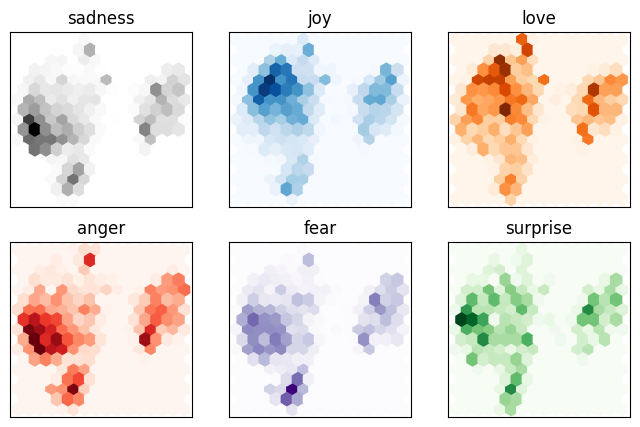

In [20]:
# 1. Set the plot configuration
fig, axes = plt.subplots(2, 3, figsize=(8, 5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = hidden_emotions["train"].features["label"].names

for i, (label, color) in enumerate(zip(labels, cmaps)):
    df_emb_tmp = df_emb.query(f"label == {i}")
    axes[i].hexbin(x=df_emb_tmp.X, y=df_emb_tmp.Y, cmap=color, gridsize=15)
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])
# 2. Build the chart

### Entrainement avec quelques classificateurs

#### Régression logistique (softmax)

In [21]:
import multiprocessing

multiprocessing.cpu_count()

12

In [ ]:
max_iter = 1000

def objective(trial):
    
    param_distributions = {
        "Cs": trial.suggest_int("C", 1, 10),
        "l1_ratios": [trial.suggest_float("l1_ratio", 0, 1)],
    }

    lr_clf = LogisticRegressionCV(
        cv=5,
        max_iter=max_iter,
        solver="saga",
        penalty="elasticnet",
        random_state=42,
        **param_distributions
    )
    lr_clf.fit(X_train, y_train)
    
    a = 5



study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(
        n_startup_trials=3, multivariate=True
    )
)
study.optimize(
    func=objective,  
    n_trials=2, 
    show_progress_bar=True
)
    
    

    

C:\Users\tddnth\workspace\nlp_exploration\.venv\Lib\site-packages\optuna\samplers\_tpe\sampler.py:295: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2023-12-22 19:34:21,118] A new study created in memory with name: no-name-55b26d9f-4dd6-41ac-a218-3b64f0bf981f


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
max_iter = 100
lr_clf = LogisticRegression(max_iter=max_iter, 
                            # n_jobs=-1, 
                            solver="saga",
                            penalty="elasticnet", 
                            random_state=42)

param_distributions = {
    "C": optuna.distributions.FloatDistribution(1e-10, 10),
    "l1_ratio": optuna.distributions.FloatDistribution(0, 1),
}

optuna_search = optuna.integration.OptunaSearchCV(lr_clf, 
                                                  cv=10,
                                                  n_jobs=5,
                                                  n_trials=5,
                                                  param_distributions=param_distributions)
optuna_search.fit(X_train, y_train)

# lr_clf.fit(X_train, y_train)
# lr_clf.score(X_test, y_test)

C:\Users\tddnth\AppData\Local\Temp\ipykernel_16524\534153907.py:13: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(lr_clf,
[I 2023-12-22 18:41:48,442] A new study created in memory with name: no-name-799c3267-807e-4a70-80b6-6722de107cd4
C:\Users\tddnth\workspace\nlp_exploration\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\tddnth\workspace\nlp_exploration\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\tddnth\workspace\nlp_exploration\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\tddnth\workspace\nlp_explora

#### Boosting tree

## En appliquant la méthode de fine-tuning sur le modèle. 